# 테슬라 종가 예측

## 라이브러리 import 

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

## 데이터 로드

In [60]:
raw_data = pd.read_csv('/content/datasets/TSLA.csv')
print(raw_data)

            Date        Open        High  ...       Close   Adj Close    Volume
0     2010-06-29    3.800000    5.000000  ...    4.778000    4.778000  93831500
1     2010-06-30    5.158000    6.084000  ...    4.766000    4.766000  85935500
2     2010-07-01    5.000000    5.184000  ...    4.392000    4.392000  41094000
3     2010-07-02    4.600000    4.620000  ...    3.840000    3.840000  25699000
4     2010-07-06    4.000000    4.000000  ...    3.222000    3.222000  34334500
...          ...         ...         ...  ...         ...         ...       ...
2753  2021-06-07  591.830017  610.000000  ...  605.130005  605.130005  22543700
2754  2021-06-08  623.010010  623.090027  ...  603.590027  603.590027  26053400
2755  2021-06-09  602.169983  611.789978  ...  598.780029  598.780029  16584600
2756  2021-06-10  603.880005  616.590027  ...  610.119995  610.119995  23919600
2757  2021-06-11  610.229980  612.559998  ...  609.890015  609.890015  16165000

[2758 rows x 7 columns]


## 데이터 전처리

In [61]:
# Date column을 datetime 타입으로 변환 후 인덱스로 사용
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.set_index('Date', inplace=True)
print(raw_data)

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2010-06-29    3.800000    5.000000  ...    4.778000  93831500
2010-06-30    5.158000    6.084000  ...    4.766000  85935500
2010-07-01    5.000000    5.184000  ...    4.392000  41094000
2010-07-02    4.600000    4.620000  ...    3.840000  25699000
2010-07-06    4.000000    4.000000  ...    3.222000  34334500
...                ...         ...  ...         ...       ...
2021-06-07  591.830017  610.000000  ...  605.130005  22543700
2021-06-08  623.010010  623.090027  ...  603.590027  26053400
2021-06-09  602.169983  611.789978  ...  598.780029  16584600
2021-06-10  603.880005  616.590027  ...  610.119995  23919600
2021-06-11  610.229980  612.559998  ...  609.890015  16165000

[2758 rows x 6 columns]


In [62]:
# 최근 1년 데이터에서 Adj Close를 제외한 column 변수에 저장
data = raw_data['2020-06-15':'2021-06-14'][raw_data.columns.difference(['Adj Close'], sort=False)]
print(data)
print(data.info())
print(data.shape)

                  Open        High         Low       Close    Volume
Date                                                                
2020-06-15  183.557999  199.768005  181.699997  198.179993  78486000
2020-06-16  202.369995  202.576004  192.477997  196.425995  70255500
2020-06-17  197.542007  201.000000  196.514008  198.358002  49454000
2020-06-18  200.600006  203.839996  198.893997  200.792007  48759500
2020-06-19  202.556000  203.194000  198.268005  200.179993  43398500
...                ...         ...         ...         ...       ...
2021-06-07  591.830017  610.000000  582.880005  605.130005  22543700
2021-06-08  623.010010  623.090027  595.500000  603.590027  26053400
2021-06-09  602.169983  611.789978  597.630005  598.780029  16584600
2021-06-10  603.880005  616.590027  600.500000  610.119995  23919600
2021-06-11  610.229980  612.559998  601.520020  609.890015  16165000

[251 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2020-06-15 to

### 결측치 제거

In [63]:
# 결측치 제거
data.dropna(inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2020-06-15 to 2021-06-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    251 non-null    float64
 1   High    251 non-null    float64
 2   Low     251 non-null    float64
 3   Close   251 non-null    float64
 4   Volume  251 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.8 KB
None


### minmax scaling

In [64]:
from sklearn.preprocessing import MinMaxScaler

In [65]:
# 0에서 1 사이의 값으로 스케일링
minmaxscaler = MinMaxScaler()
scaled_data = minmaxscaler.fit_transform(data)
print(scaled_data[:6])
print(scaled_data.shape)

[[0.         0.00365755 0.         0.00901695 0.30598038]
 [0.0265773  0.0076507  0.01562255 0.00647913 0.26621346]
 [0.01975639 0.00540953 0.02147269 0.00927451 0.16570783]
 [0.02407668 0.00944818 0.02492245 0.01279623 0.16235224]
 [0.02684008 0.00852953 0.02401509 0.01191071 0.13644975]
 [0.02321488 0.00651305 0.02363241 0.01000663 0.0804678 ]]
(251, 5)


**RNN(순환 신경망) - 입력과 출력을 시퀀스 단위로 처리**

### feature, target 시퀀스화

In [66]:
# 각 길이가 28인 시퀀스로 만듦
sequence_X = []
sequence_Y = []
for i in range(len(scaled_data) - 28):
    _x = scaled_data[i:i+28] # i ~ i+27번째가 feature
    _y = scaled_data[i+28][3] # i+28번째가 label
    if i is 0:
        print(_x, '->', _y)
    sequence_X.append(_x)
    sequence_Y.append(_y)

[[0.00000000e+00 3.65755301e-03 0.00000000e+00 9.01695272e-03
  3.05980379e-01]
 [2.65772975e-02 7.65070280e-03 1.56225545e-02 6.47912703e-03
  2.66213458e-01]
 [1.97563906e-02 5.40952677e-03 2.14726938e-02 9.27451049e-03
  1.65707825e-01]
 [2.40766843e-02 9.44817829e-03 2.49224533e-02 1.27962251e-02
  1.62352242e-01]
 [2.68400824e-02 8.52953167e-03 2.40150870e-02 1.19107139e-02
  1.36449750e-01]
 [2.32148843e-02 6.51304861e-03 2.36324127e-02 1.00066263e-02
  8.04678007e-02]
 [2.29125428e-02 7.40040559e-03 2.47891079e-02 1.21653794e-02
  8.05378596e-02]
 [2.15647534e-02 4.23774025e-03 1.29410194e-02 3.21207495e-04
  1.91528179e-01]
 [1.03076832e-02 0.00000000e+00 8.30554598e-03 7.59323088e-03
  1.50335921e-01]
 [2.17540496e-02 2.56540198e-03 1.34425312e-02 0.00000000e+00
  1.40682278e-01]
 [1.44725693e-02 6.83158917e-03 1.16016789e-02 1.43559451e-02
  1.44825420e-01]
 [2.50656293e-02 2.89275861e-02 2.76069076e-02 3.47454025e-02
  3.35484868e-01]
 [4.66812373e-02 4.24769966e-02 4.986231

In [67]:
# ndarray 타입으로 변환
sequence_X = np.array(sequence_X)
sequence_Y = np.array(sequence_Y)
print(sequence_X[1])
print(sequence_Y[1])
print(sequence_X.shape)
print(sequence_Y.shape)

[[2.65772975e-02 7.65070280e-03 1.56225545e-02 6.47912703e-03
  2.66213458e-01]
 [1.97563906e-02 5.40952677e-03 2.14726938e-02 9.27451049e-03
  1.65707825e-01]
 [2.40766843e-02 9.44817829e-03 2.49224533e-02 1.27962251e-02
  1.62352242e-01]
 [2.68400824e-02 8.52953167e-03 2.40150870e-02 1.19107139e-02
  1.36449750e-01]
 [2.32148843e-02 6.51304861e-03 2.36324127e-02 1.00066263e-02
  8.04678007e-02]
 [2.29125428e-02 7.40040559e-03 2.47891079e-02 1.21653794e-02
  8.05378596e-02]
 [2.15647534e-02 4.23774025e-03 1.29410194e-02 3.21207495e-04
  1.91528179e-01]
 [1.03076832e-02 0.00000000e+00 8.30554598e-03 7.59323088e-03
  1.50335921e-01]
 [2.17540496e-02 2.56540198e-03 1.34425312e-02 0.00000000e+00
  1.40682278e-01]
 [1.44725693e-02 6.83158917e-03 1.16016789e-02 1.43559451e-02
  1.44825420e-01]
 [2.50656293e-02 2.89275861e-02 2.76069076e-02 3.47454025e-02
  3.35484868e-01]
 [4.66812373e-02 4.24769966e-02 4.98623134e-02 4.62683438e-02
  2.48718042e-01]
 [8.58097170e-02 6.88335181e-02 8.033048

## train, test 분리

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(
    sequence_X, sequence_Y, test_size=0.2
)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(178, 28, 5)
(178,)
(45, 28, 5)
(45,)


## 모델 생성

RNN은 시퀀스의 길이가 길어질수록 성능이 떨어지기 때문에 보다 발전한 LSTM 사용

GRU: LSTM과 비슷한 성능, 높은 효율(빠른 학습)

In [70]:
model = Sequential()
model.add(GRU(50,
              input_shape=(X_train.shape[1], X_train.shape[2]),  # input_shape=(28, 5)
              activation='tanh',  # LSTM에서 사용
              ))  
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(1))  # 값 예측이기 때문에 activation 사용 없이 값을 그대로 반환
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                8550      
_________________________________________________________________
flatten_2 (Flatten)          (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 8,601
Trainable params: 8,601
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [71]:
fit_hist = model.fit(X_train, Y_train, epochs=500, validation_data=(X_test, Y_test), shuffle=False) # validation_data는 학습에 영향 x

Epoch 1/500
6/6 [==============================] - 3s 107ms/step - loss: 0.0213 - val_loss: 0.0039
Epoch 2/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0194 - val_loss: 0.0022
Epoch 3/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0178 - val_loss: 0.0018
Epoch 4/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0139 - val_loss: 0.0026
Epoch 5/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0107 - val_loss: 0.0020
Epoch 6/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0103 - val_loss: 0.0030
Epoch 7/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0085 - val_loss: 0.0017
Epoch 8/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0094 - val_loss: 0.0015
Epoch 9/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0095 - val_loss: 0.0068
Epoch 10/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0090 - val_loss: 0.0012
Epoch 11/500
6/6 [

## 결과 확인

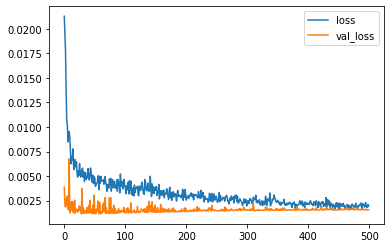

In [72]:
# test, train loss 비교
plt.plot(fit_hist.history['loss'], label='loss')
plt.plot(fit_hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [73]:
predict = model.predict(X_test)

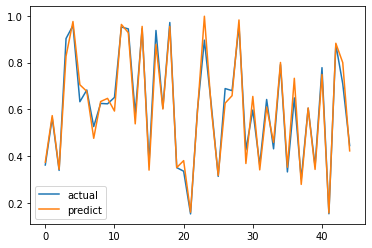

In [74]:
# test, predict 결과 값 비교
plt.plot(Y_test, label='actual')
plt.plot(predict, label='predict')
plt.legend()
plt.show()

# 두달치 데이터 예측

In [75]:
# 최근 2달치 데이터에서 Adj Close를 제외한 column 변수에 저장
test_data = raw_data['2021-04-15':'2021-06-15'][raw_data.columns.difference(['Adj Close'], sort=False)]
print(test_data)
print(test_data.info())
print(test_data.shape)

                  Open        High         Low       Close    Volume
Date                                                                
2021-04-15  743.099976  743.690002  721.309998  738.849976  27848900
2021-04-16  728.650024  749.409973  724.599976  739.780029  27979500
2021-04-19  719.599976  725.400024  691.799988  714.630005  39686200
2021-04-20  717.419983  737.250000  710.690002  718.989990  35609000
2021-04-21  704.770020  744.840027  698.000000  744.119995  31215500
2021-04-22  741.500000  753.770020  718.039978  719.690002  35590300
2021-04-23  719.799988  737.359985  715.460022  729.400024  28370000
2021-04-26  741.000000  749.299988  732.609985  738.200012  31038500
2021-04-27  717.960022  724.000000  703.349976  704.739990  29437000
2021-04-28  696.409973  708.500000  693.599976  694.400024  22271000
2021-04-29  699.510010  702.250000  668.500000  677.000000  28845400
2021-04-30  667.590027  715.469971  666.140015  709.440002  40758700
2021-05-03  703.799988  706.000000

### minmax scling

In [76]:
# 기존에 fit 되어있는 스케일러를 사용해 스케일링
scaled_test_data = minmaxscaler.transform(test_data)
print(scaled_test_data[:6])
print(scaled_test_data.shape)

[[0.79051226 0.77714857 0.78215686 0.79130187 0.06131948]
 [0.7700976  0.78528273 0.78692563 0.79264754 0.06195049]
 [0.75731183 0.75113908 0.73938253 0.75625846 0.1185132 ]
 [0.75423197 0.76799049 0.76676333 0.76256684 0.09881359]
 [0.73636029 0.77878398 0.74836936 0.79892696 0.07758572]
 [0.78825184 0.79148299 0.77741701 0.76357967 0.09872324]]
(41, 5)


#### scaling 되어있는 값을 원래의 값으로 inverse transform

In [77]:
scaled_test_data[39][3]

0.6050449537919796

In [78]:
predict_value = minmaxscaler.inverse_transform(scaled_test_data[30].reshape(-1, 5))
print(predict_value)

[[6.20239990e+02 6.31130005e+02 6.16210022e+02 6.30849976e+02
  2.63706000e+07]]


In [79]:
print(test_data.iloc[39])

Open      6.038800e+02
High      6.165900e+02
Low       6.005000e+02
Close     6.101200e+02
Volume    2.391960e+07
Name: 2021-06-10 00:00:00, dtype: float64


## feature, target 시퀀스화

In [80]:
# feature, target 시퀀스화
sequence_testdata_X = []
sequence_testdata_Y = []
for i in range(len(scaled_test_data) - 28):
    _x = scaled_test_data[i:i+28]
    _y = scaled_test_data[i+28][3]
    sequence_testdata_X.append(_x)
    sequence_testdata_Y.append(_y)

# ndarray로 변환
sequence_testdata_X = np.array(sequence_testdata_X)
sequence_testdata_Y = np.array(sequence_testdata_Y)
print(sequence_testdata_X.shape)
print(sequence_testdata_Y.shape)

(13, 28, 5)
(13,)


## 기존에 학습된 모델로 예측

In [81]:
predict_test = model.predict(sequence_testdata_X)

## 결과 확인

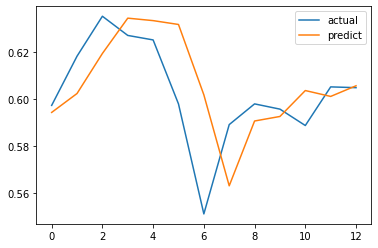

In [82]:
plt.plot(sequence_testdata_Y, label='actual')
plt.plot(predict_test, label='predict')
plt.legend()
plt.show()

# 가장 최근 데이터 예측

In [83]:
# 가장 최근 28일 데이터
last_28_data = scaled_test_data[-28:]
last_28_data.shape

(28, 5)

In [84]:
# 예측에 사용하기 위해 reshape
last_28_data = last_28_data.reshape(-1, 28, 5)
last_28_data

array([[[0.69986804, 0.69148355, 0.68995511, 0.69689291, 0.07045323],
        [0.70286314, 0.69411433, 0.70392817, 0.69304424, 0.03258564],
        [0.70243932, 0.68802795, 0.67879405, 0.68233729, 0.0610088 ],
        [0.68130404, 0.70079804, 0.69360775, 0.69511327, 0.04015828],
        [0.68003258, 0.66531756, 0.64634005, 0.63241991, 0.07844044],
        [0.5872691 , 0.61135028, 0.59994201, 0.61528889, 0.15145397],
        [0.59186065, 0.60183668, 0.58714312, 0.57577459, 0.09018715],
        [0.59051849, 0.58199898, 0.54783308, 0.54944134, 0.14024936],
        [0.56490469, 0.56267311, 0.56350201, 0.57555752, 0.08799986],
        [0.55380023, 0.55820781, 0.55007976, 0.55687833, 0.08326243],
        [0.54313372, 0.56747969, 0.55323963, 0.55838305, 0.10471594],
        [0.52130618, 0.52476097, 0.52946803, 0.53753354, 0.11799235],
        [0.55302321, 0.55695639, 0.56438617, 0.57127481, 0.07568012],
        [0.58284708, 0.56809117, 0.57733007, 0.56273818, 0.05253408],
        [0.56234756,

In [85]:
# 기존에 학습된 모델로 예측
today_close = model.predict(last_28_data)
print(today_close)

[[0.60662466]]


In [86]:
minmaxscaler_close = MinMaxScaler()
minmaxscaler_close.fit(data[['Close']])  # 예측값을 inverse_transform하기 위해 Close 하나만 받는 스케일러 fit

MinMaxScaler(copy=True, feature_range=(0, 1))

In [87]:
# 예측 값 inverse transform
today_close = minmaxscaler_close.inverse_transform(today_close)
today_close

array([[611.2118]], dtype=float32)